# 출처
- https://www.kaggle.com/rgaddati/unsupervised-fraud-detection-isolation-forest/notebook

In [1]:
##All General Import Statements
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot
import os
# print(os.listdir("../input"))
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Anomaly Detection Algorithms: Isolation Forest vs the Rest

해당 노트북에서는 Isolation Forest 알고리즘을 단순화 시켜 구현한다. 또한 Scikit-learn 구현을 다른 인기 있는 이상 탐지 알고리즘과 비교한다. (KMeans, 로컬 이상값 요인, 단일 클래스 SVM)

실제 시나리오에서 비지도 모델은 도메인 지식을 기반으로 하는 이상규칙이 문제에 대해 공식화될 수 없는 경우 레이블이 지정된 데이터를 생성하기 위한 시드로 주로 사용됩니다. 예를 들어, 문제가 로그인 간 시간 및 출처 간 거리와 같은 네트워크 트래픽 메트릭의 이상을 식별하는 것인 경우 이상규칙을 만드는데 사용될 수 있다. 그런 다음 이 규칙을 적용하여 얻은 비정상적인 데이터를 통해 실제 데이터를 비교 확인해봐야 한다.반면 직원이 증권 사기를 저지를 확률을 식별하는 경우는 데이터는 매우 고차원적이며 데이터 포인트 간의 관계가 복잡합니다. 따라서 깊이 있는 도메인 지식 없이는 이상규칙을 만들어내기가 어렵다. 이는 기밀 유지와 같은 문제와 결합되어 이러한 위험 규칙을 검증하기가 매우 어렵습니다.

그렇기 때문에 비지도 학습이 유용하다.도메인 지식이 거의 없는 상태에서 간단한 비지도 알고리즘을 사용하여 비정상적인 목록을 만든 다음 감사 프로세스에 입력하여 실제 레이블을 생성할 수 있습니다. 시간이 지남에 따라 충분한 데이터 레이블이 생성되면 비지도 문제를 다시 지도문제로 변경할 수도있을 것이다.

이 노트북은 다양한 비지도 알고리즘을 서로 비교하는 것을 목표로 하기 때문에 실제 성능을 검증한다. 이를 위해 레이블이 지정된 데이터 세트를 사용합니다. 그러나 알고리즘은 훈련하는 동안 레이블을 보지 못합니다. 레이블은 모델 예측을 실제 값과 비교하고 성능 메트릭을 만드는 데만 사용된다.

## Isolation Forests in Python

The Algorithm has 3 parts:
    1. Forest
    2. Isolation Tree
    3. Evaluation (Path Length)

### Common Classes

The below code defines classes for external and internal nodes

In [3]:
class ExNode:
    def __init__(self,size):
        self.size=size
        
class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

### Forest

In [4]:
def iForest(X,noOfTrees,sampleSize):
    forest=[]
    hlim=math.ceil(math.log(sampleSize,2))
    for i in range(noOfTrees):
        X_train=X.sample(sampleSize)
        forest.append(iTree(X_train,0,hlim))
    return forest

### Isolation Tree

In [5]:
def iTree(X,currHeight,hlim):
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<p]
        X_r=X[X[q]>=p]
        return InNode(iTree(X_l,currHeight+1,hlim),iTree(X_r,currHeight+1,hlim),q,p)

### Path Length

In [6]:
def pathLength(x,Tree,currHeight):
    if isinstance(Tree,ExNode):
        return currHeight
    a=Tree.splitAtt
    if x[a]<Tree.splitVal:
        return pathLength(x,Tree.left,currHeight+1)
    else:
        return pathLength(x,Tree.right,currHeight+1)

## Test Run

- 데이터 셋의 출처는 아래와 같다. 
- 신용카드 사용의 farud 관련 데이터이다.
- Source: https://www.kaggle.com/dalpozz/creditcardfraud


In [7]:
df=pd.read_csv("C:/Users/user/Dropbox/Taehoon/github_local/example/archive/creditcard.csv")
y_true=df['Class']
df_data=df.drop('Class',1)

Next, we create the forest.

In [8]:
sampleSize=10000
ifor=iForest(df_data.sample(100000),10,sampleSize) ##10개의 iFOREST

Next, we select 1000 random datapoints and get their path lengths. The purpose for this is to plot and see if anomalies actually have shorter path lengths.

In [9]:
posLenLst=[]
negLenLst=[]

for sim in range(1000):
    ind=random.choice(df_data[y_true==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(df_data.iloc[ind],tree,0))
        
    ind=random.choice(df_data[y_true==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(df_data.iloc[ind],tree,0))

Finally, we plot the path lengths.

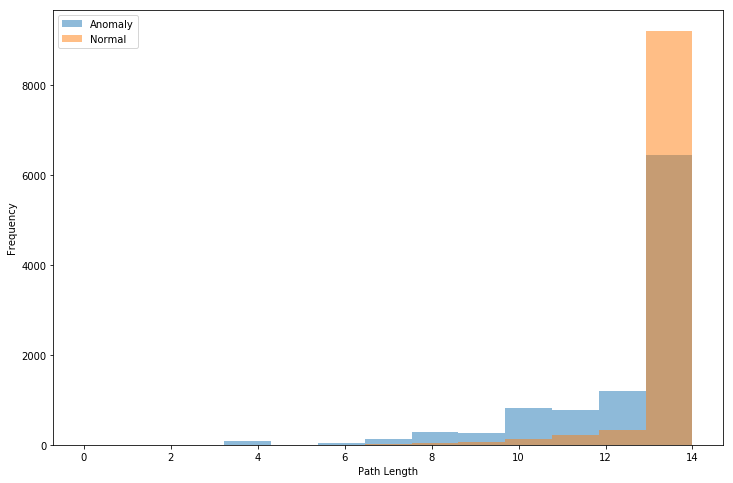

In [10]:
bins = np.linspace(0,math.ceil(math.log(sampleSize,2)), math.ceil(math.log(sampleSize,2)))

pyplot.figure(figsize=(12,8))
pyplot.hist(posLenLst, bins, alpha=0.5, label='Anomaly')
pyplot.hist(negLenLst, bins, alpha=0.5, label='Normal')
pyplot.xlabel('Path Length')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper left')

Anomalies do seem to have a lower path length. Not bad for random division!

#### Notes:

The above implementation ignores three aspects of the actual algorithm fo the sake of simplicity.
1. The average depth needs to be added to the depth once the current length hits the height limit
2. The path lengths are not normalized between trees and hence the actual values are used for plotting
3. The authors of the paper suggest using kurtosis to select features as a refinement over random selection

## Plotting the Data

T-SNE를 사용해 고차원의 데이터를 2차원과 3차원의 plot으로 나타내 확인해보았다. 목적은 거리기반의 이상탐지 알고리즘이 이 데이터 셋에서도 잘 작동하는지 이다. 하지만  T-SNE의 결과 이상치와 정상데이터가 멀리 떨어져 있지 않음을 확인하였고 `이를 통해 거리기반의 이상탐지 알고리즘은 잘 작동하지 않을거라고 생각되어진다.`

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
from sklearn.manifold import TSNE

In [15]:
df_plt=df[df['Class']==0].sample(1000)
df_plt_pos=df[df['Class']==1].sample(20)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['Class']
X_plt=df_plt.drop('Class',1)

In [16]:
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

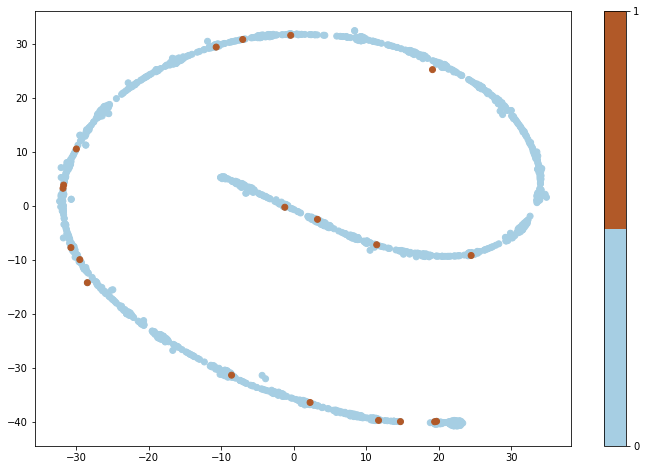

In [17]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))
pyplot.colorbar(ticks=range(2))

In [18]:
X_embedded = TSNE(n_components=3).fit_transform(X_plt)

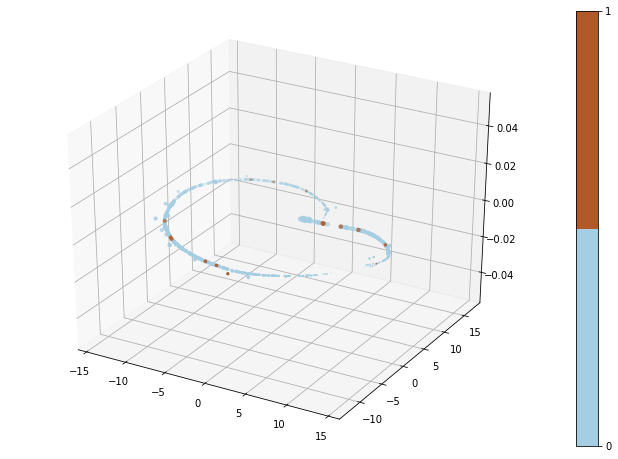

In [19]:
pyplot.figure(figsize=(12,8))
pyplot.axes(projection='3d')
pyplot.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))
pyplot.colorbar(ticks=range(2))

## 다양한 알고리즘 적합 및 평가확인

To keep things even, all of the algorithms are run with their default parameters.

Let's start by importing the scikit-learn implementations of all 4 algorithms.

In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans

Next, let's create a train and test dataset.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.3, random_state=42)

Finally, let's create a few helper functions that help with training and testing the models. The preprocess function is not used in this notebook but it might help improve the scores on the KMeans and One Class SVM models.

In [23]:
## Not required for Isolation Forest
def preprocess(df_data):
    for col in df_data:
        df_data[col]=(df_data[col]-np.min(df_data[col]))/(np.max(df_data[col])-np.min(df_data[col]))
    return

<b>Note:</b> The below train and predict functions are designed to output ensemble models (bagged models), with the default size being 5 models. The Isolation Forest and One Class SVM use these functions.

In [24]:
## Not valid for LOF
def train(X,clf,ensembleSize=5,sampleSize=10000):
    mdlLst=[]
    for n in range(ensembleSize):
        X=df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    return mdlLst

In [25]:
## Not valif for LOF
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

Finally, let's import some model scoring libraries. Since, we are dealing with a heavily imbalanced dataset, F1 Score is used as a proxy for model performance.

For more details, refer http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

#### Isolation Forest

In [27]:
alg=IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0,behaviour="new")

<b>Note:</b> The magic function timeit does not let us use any variable that is created in the timeit cell. Hence, every cell with a timeit magic function will have a corresponding regular cell with the same code.

In [28]:
%%timeit
if_mdlLst=train(X_train,alg)

2.43 s ± 96.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
if_mdlLst=train(X_train,alg)

In [30]:
%%timeit
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

13.9 s ± 93.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

In [32]:
roc_auc_score(y_test, if_y_pred_class)

0.8947409839479418

In [33]:
f1_score(y_test, if_y_pred_class)

0.05171240644136993

In [34]:
if_cm=confusion_matrix(y_test, if_y_pred_class)

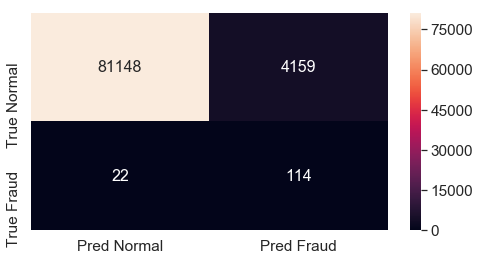

In [35]:
import seaborn as sn
     
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

#### KMeans

The top 5% of the farthest point from cluster centers are itentified as fraud (outliers)

In [36]:
%%timeit

kmeans = KMeans(n_clusters=8, random_state=42,n_jobs=-1).fit(X_train)

17 s ± 77.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
kmeans = KMeans(n_clusters=8, random_state=42,n_jobs=-1).fit(X_train)

In [38]:
%%timeit
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

440 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

In [40]:
roc_auc_score(y_test, km_y_pred)

0.5191431432080258

In [41]:
f1_score(y_test, km_y_pred)

0.005443411204354729

In [42]:
km_cm=confusion_matrix(y_test, km_y_pred)

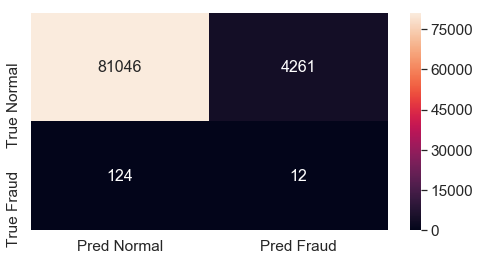

In [43]:
df_cm = pd.DataFrame(km_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

#### LOF

Local Outlier Factor only looks at the local neighbourhood of a data point and hence cannot make predictions on out of sample data points. Hence we work directly with X_test here.

In [44]:
clf=LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, \
                   metric='minkowski', p=2, metric_params=None, contamination=0.1, n_jobs=-1)

In [45]:
%%timeit
clf.fit(X_test)

872 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
clf.fit(X_test)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=-1,
          n_neighbors=20, novelty=False, p=2)

In [47]:
%%timeit
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

1.97 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [48]:
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

In [49]:
roc_auc_score(y_test, lof_y_pred_class)

0.4970491525762661

In [50]:
f1_score(y_test, lof_y_pred_class)

0.0027217056021773644

In [51]:
lof_cm=confusion_matrix(y_test, lof_y_pred_class)

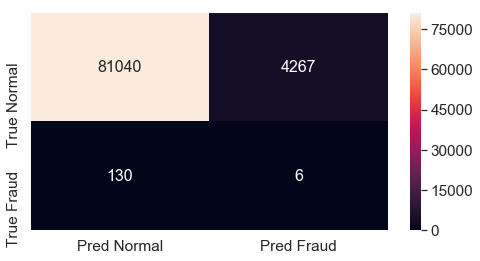

In [52]:
df_cm = pd.DataFrame(lof_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

#### One-Class SVM*

##### *Any kernel except linear will take a while. Feel free to grab a coffee, if you decide to change the kernel type

In [53]:
alg=OneClassSVM(kernel='linear',gamma='auto', coef0=0.0, tol=0.001, nu=0.5, \
                shrinking=True, cache_size=500, verbose=False, max_iter=-1)

In [54]:
%%timeit
osvm_mdlLst=train(X_train,alg)

12.6 s ± 71.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
osvm_mdlLst=train(X_train,alg)

In [56]:
%%timeit
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

45.8 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

In [58]:
roc_auc_score(y_test, osvm_y_pred_class)

0.5106923937005377

In [59]:
f1_score(y_test, osvm_y_pred_class)

0.0033086350715317587

In [60]:
osvm_cm=confusion_matrix(y_test, osvm_y_pred_class)

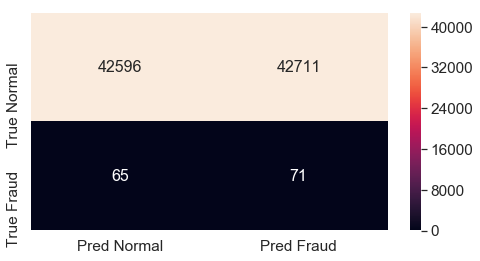

In [61]:
df_cm = pd.DataFrame(osvm_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

## Conclusion

In [62]:
## Performance Plot
train_times={
    'Isolation Forest': 4.38,
    'KMeans':20.9,
    'LOF':2.06,
    'OneClass SVM': 21.4
}

prediction_times={
    'Isolation Forest':34.2,
    'KMeans':0.052,
    'LOF':0.00368,
    'OneClass SVM': 71
}

Text(0.5, 0, 'Time in seconds')

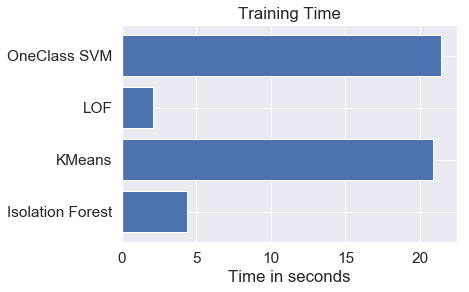

In [63]:
pyplot.title('Training Time')
pyplot.barh(range(len(train_times)), list(train_times.values()), align='center')
pyplot.yticks(range(len(train_times)), list(train_times.keys()))
pyplot.xlabel('Time in seconds')

Isolation forest has the 2nd fastest training time. This is very impressive considering that our model is actually an ensemble of 5 Isolation forest models.

Text(0.5, 0, 'Time in seconds')

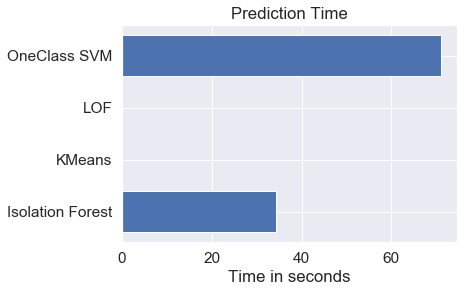

In [64]:
pyplot.title('Prediction Time')
pyplot.barh(range(len(prediction_times)), list(prediction_times.values()), align='center')
pyplot.yticks(range(len(prediction_times)), list(prediction_times.keys()))
pyplot.xlabel('Time in seconds')

The algorithm doesn't fare so well but this might be due to the over head of the ensemble structure.

In [65]:
## Performance Plot
auc_scores={
    'Isolation Forest': roc_auc_score(y_test, if_y_pred_class),
    'KMeans':roc_auc_score(y_test, km_y_pred),
    'LOF':roc_auc_score(y_test, lof_y_pred_class),
    'OneClass SVM': roc_auc_score(y_test, osvm_y_pred_class)
}

f1_scores={
    'Isolation Forest':f1_score(y_test, if_y_pred_class),
    'KMeans':f1_score(y_test, km_y_pred),
    'LOF':f1_score(y_test, lof_y_pred_class),
    'OneClass SVM': f1_score(y_test, osvm_y_pred_class)
}

Text(0.5, 0, 'AUC Score')

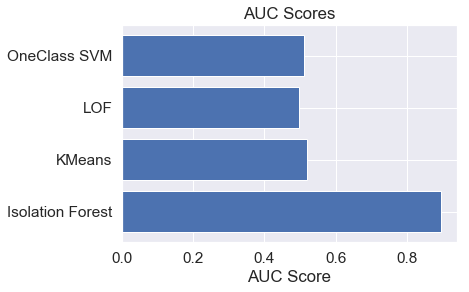

In [66]:
pyplot.title('AUC Scores')
pyplot.barh(range(len(auc_scores)), list(auc_scores.values()), align='center')
pyplot.yticks(range(len(auc_scores)), list(auc_scores.keys()))
pyplot.xlabel('AUC Score')

Text(0.5, 0, 'F1 Score')

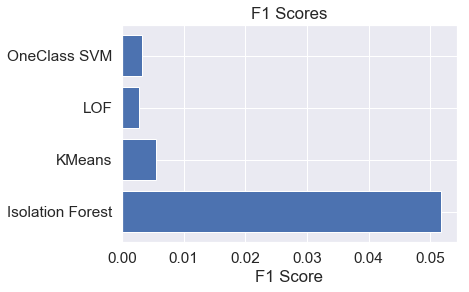

In [67]:
pyplot.title('F1 Scores')
pyplot.barh(range(len(f1_scores)), list(f1_scores.values()), align='center')
pyplot.yticks(range(len(f1_scores)), list(f1_scores.keys()))
pyplot.xlabel('F1 Score')

Coming to model performance, our isolation forest ensemble model is a clear winner!